# Automated Image Analysis: Diatoms & Infection Status

Diatoms are important phytoplankton with global distribution. Like many ocean microbes, they're susceptible to infection from a panoply of parasitic symbionts (yes, even other proptists 👀). Diatom infections are easy to visualize when the staining structure is comprised of carbon-based macromolecules (*e.g.* chitin, carbon) with CalcoFluor White (CFW) and fluorescent microscopy. This is because diatom frustules are silica-based, so we can expect healthy cells to fluoresce red (due to functioning chlorophylls) and the infective structures to fluoresce blue. 

Unfortunately, most image analysis software is designed for white backgrounds and circular cells, which pennate diatoms are not (🥲). Additionally, due to the stubborn chemistry of CFW and the nature of staining on a filter, our images are rife with noisy background. Moreover, manual image analysis is time-consuming (~7-10 minutes per image) and, thus, unfeasible with a high volume of micrographs (*e.g.* 610). For these reasons (and because I adore long-winded rabbit holes 🕳🐇), I've embarked on a journey to automate our image analysis with Python! 🐍 

**Here, I test out 2 approaches to image analysis:** 
- Canny Edge Detection
- Color Masking

Many more exist and several more are in the works, so stay tuned!

## Load packages

In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage import filters
import skimage
import matplotlib.pyplot as plt

## Step 1: Read in Images in RGB & Greyscale
We will try out a few popular methods on both RGB and Greyscale. However, other methods require alternative image types, like HSV and 8-bit images.

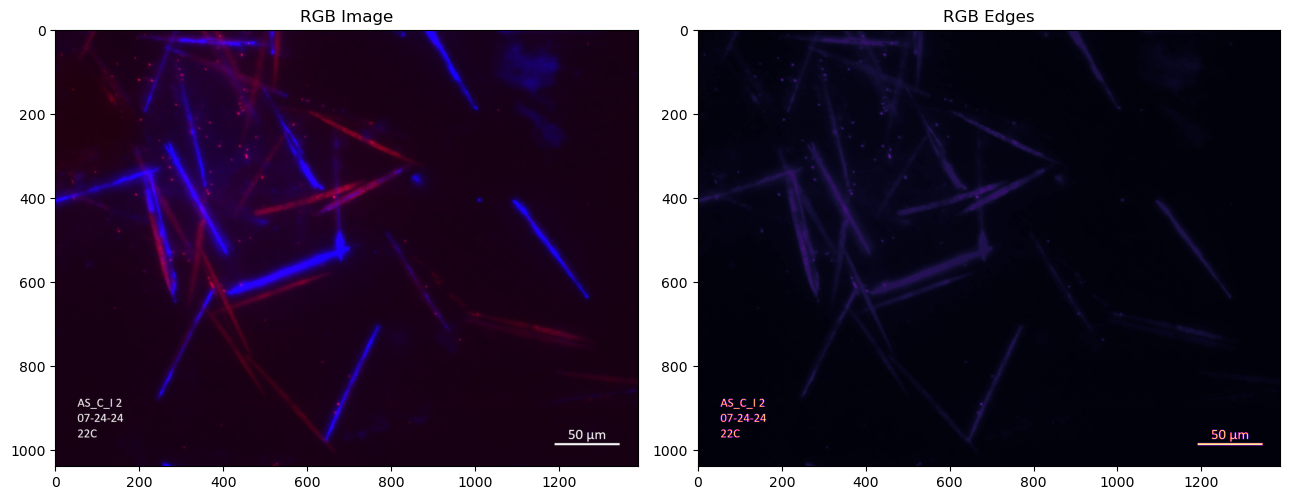

In [2]:
# Read in image
image = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # wd filepath
# image = cv2.imread("../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # GH filepath

# Step 1: Convert to grayscale and RGB
    # read in greyscale/bw
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # read in RGB version
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
ax[0].imshow(image_rgb, cmap='magma')
ax[1].imshow(gray, cmap='magma')
    # set the title to all subplots
ax[0].set_title("RGB Image")
ax[1].set_title("RGB Edges")
    # adjust spacing
fig.tight_layout()

Next, we'll use Canny edge detection to delineate cell boundaries against the environment. Canny edge detection works by:
- Noise reduction (Gaussian blur)
    - this uses a kernel (of a specified size) to blur the surrounding area, producing an average intensity for a given pixel
- Calculating the intensity gradient (Sobel kernel)
    - fine-tuning happens by adjusting the aperture
- Non-maximum suppression
    - gradient magnitude is thresholded, removes weak edges
- Hystersis thresholding
    - uses threshold to determine edges (also called contours)

## Step 2 (Approach 1): Canny Edge Detection for RBG & Greyscale

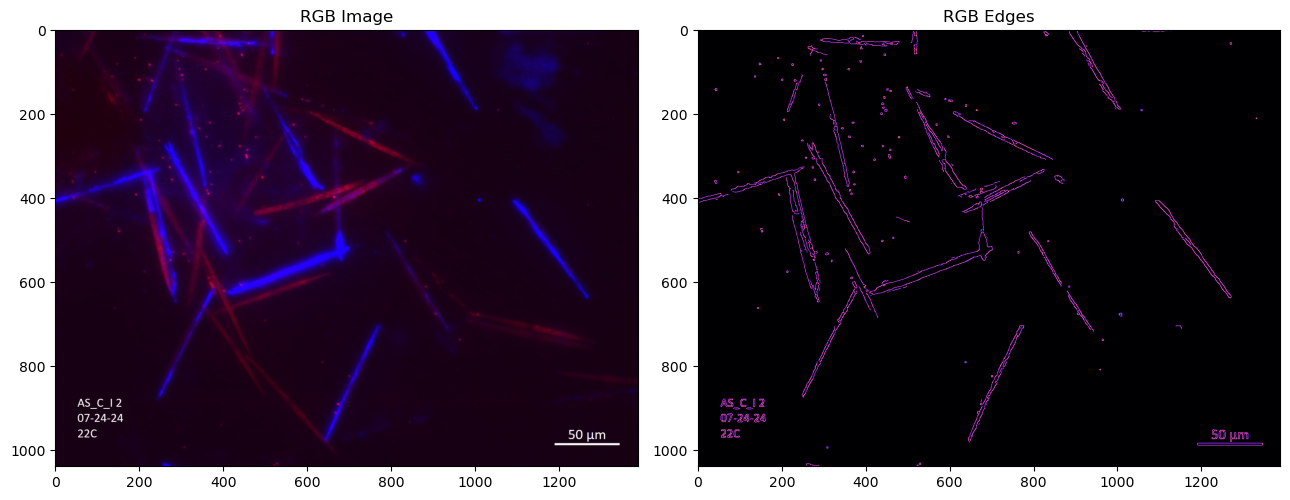

In [8]:
# Step 2: Apply Canny edge detection for RGB images
edges_rgb = cv2.Canny(image_rgb, threshold1=50, threshold2=150, apertureSize=3, L2gradient=False)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
    # show plots
ax[0].imshow(image_rgb, cmap='magma')
ax[1].imshow(edges_rgb, cmap='magma')
    # set the title to all subplots
ax[0].set_title("RGB Image")
ax[1].set_title("RGB Edges")
    # adjust spacing
fig.tight_layout()


Wow, great edges bro! Can greyscale perform?

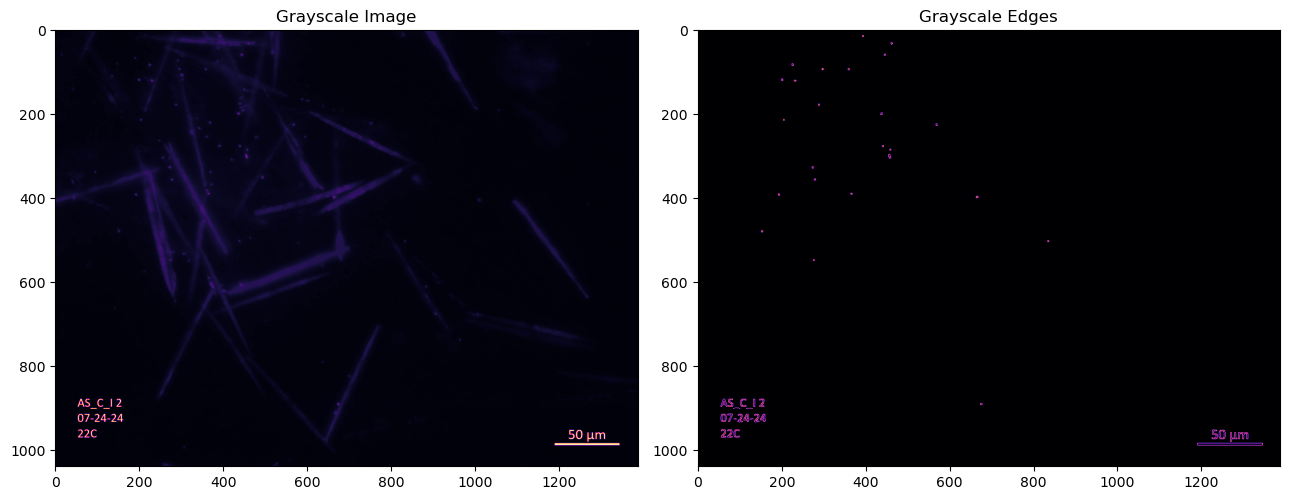

In [9]:
# Step 2: Apply Canny edge detection for greyscale images
edges_bw = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3, L2gradient=False)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
    # show figs
ax[0].imshow(gray, cmap='magma')
ax[1].imshow(edges_bw, cmap='magma')
    # set the title to all subplots
ax[0].set_title("Grayscale Image")
ax[1].set_title("Grayscale Edges")
    # adjust spacing
fig.tight_layout()

Yikes! What happened with the greyscale? Perhaps the blurring effect was too harsh given the lack of intensity imposed by the greyscale... I don't know 🤷🏼

## Step 3: Refined Edge Detection for Greyscale

To refine our edge detection in the greyscale image we'll implement the steps individually for more granular control. Our approach includes steps for:
- blurring
- defining our kernel
- applying kernel to morphology
- creating a mask (this one should be a lower bound/loose)
- extracting contours from the image (these should be less strict/loose)
- calculating the area of each contour, requiring that contour areas are between 50 - 5000 pixels
    - given the dimensions of this image (1388 x 1040 pixels), we expect the cells to be width = 5px & length = 200px, so the average area could be ~1000px
- stretch the image based on minimum and maximum values from greyscale mask
- rescale the intensity
- apply the Sobel filter for new edges (based on rescaled intensity)
- create a new mask
- draw countours again (these should be more strict)

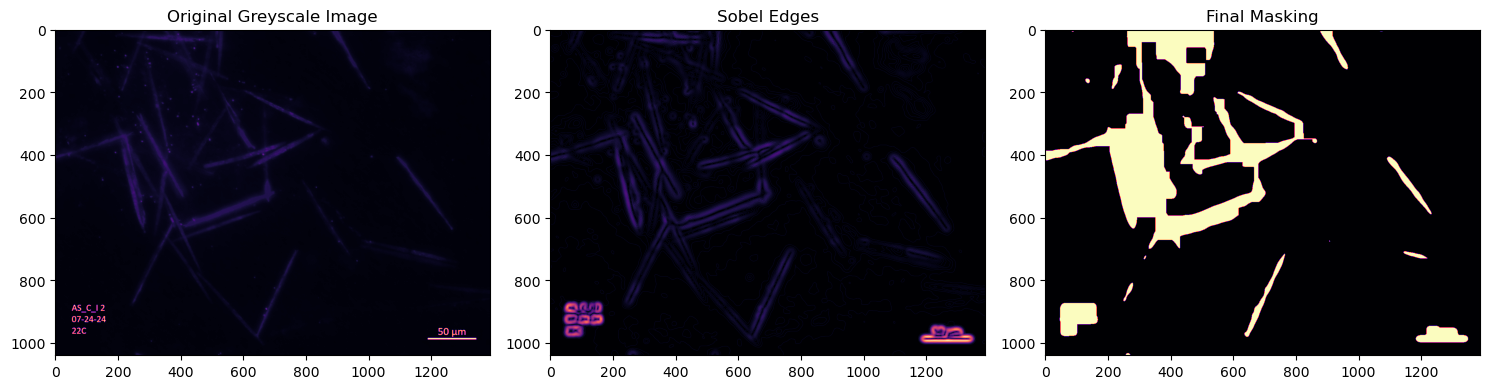

In [10]:
# Step 3: Refine edge detection
    # add a Guassian blur
blurred = cv2.GaussianBlur(gray, (0,0), sigmaX=6, sigmaY=6)
    # morphology
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45,45))
morph = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)
    # threshold
thresh = cv2.threshold(morph, 0, 255, cv2.THRESH_OTSU)[1]
    # get contours and filter on size
masked1 = gray.copy()
meanval = int(np.mean(masked1))
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    area = cv2.contourArea(cntr)
    # NOTE: maybe increase pixel size here--match threshold from before, but is this by total pixels in area of contour..?
    if area > 100 and area < 10000:
        cv2.drawContours(masked1, [cntr], 0, (meanval), -1)
# stretch image based on min & max values detected (dark to light)
minval = int(np.amin(masked1))
maxval = int(np.amax(masked1))
# NOTE: result1 is currently the same as 'gray'
result1 = skimage.exposure.rescale_intensity(masked1, in_range=(minval,maxval), out_range=(0,255)).astype(np.uint8)
    # apply sobel masking?
edges = filters.sobel(blurred) #replaced 'result1'
    # Mask to isolate the cells
mask = np.zeros_like(gray)
cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # set main title
# plt.suptitle("Refined Edge Detection & Masking")
ax[0].imshow(gray, cmap='magma')
ax[1].imshow(edges, cmap='magma')
ax[2].imshow(mask, cmap='magma')
    # set the title to all subplots
ax[0].set_title("Original Greyscale Image")
ax[1].set_title("Sobel Edges")
ax[2].set_title("Final Masking")
    # adjust spacing
fig.tight_layout()


## Step 4 (Approach 2): Extract Color Channels (Red & Blue) for Masking

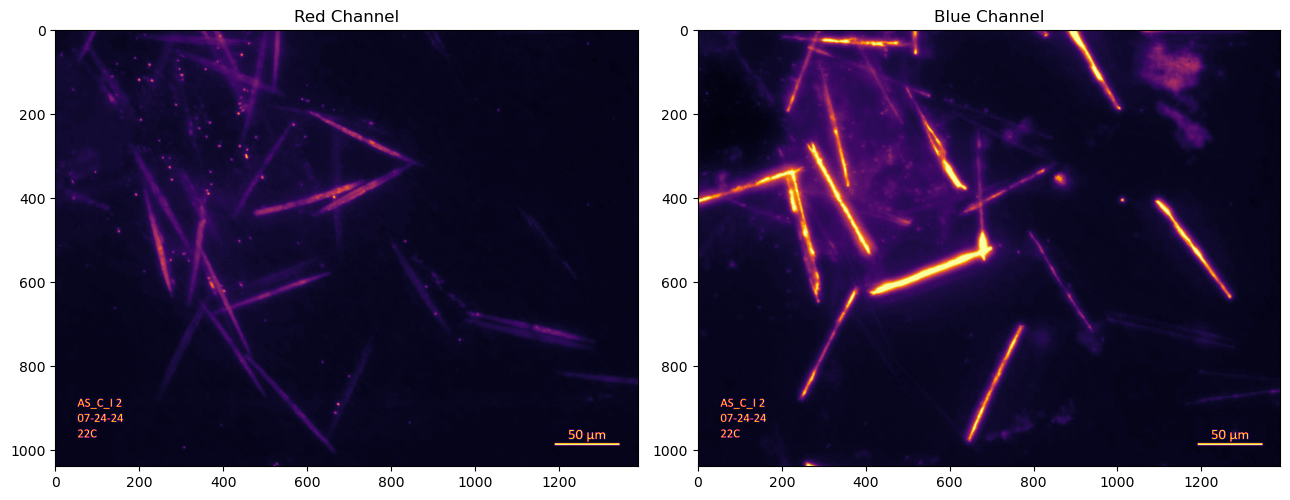

In [11]:
# Step 4: Split image into color channels
red_channel = image_rgb[:, :, 0]
green_channel = image_rgb[:, :, 1]
blue_channel = image_rgb[:, :, 2]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Channels")
ax[0].imshow(red_channel, cmap='inferno')
ax[1].imshow(blue_channel, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Red Channel")
ax[1].set_title("Blue Channel")
    # adjust spacing
fig.tight_layout()


### Create Color Channel Masks

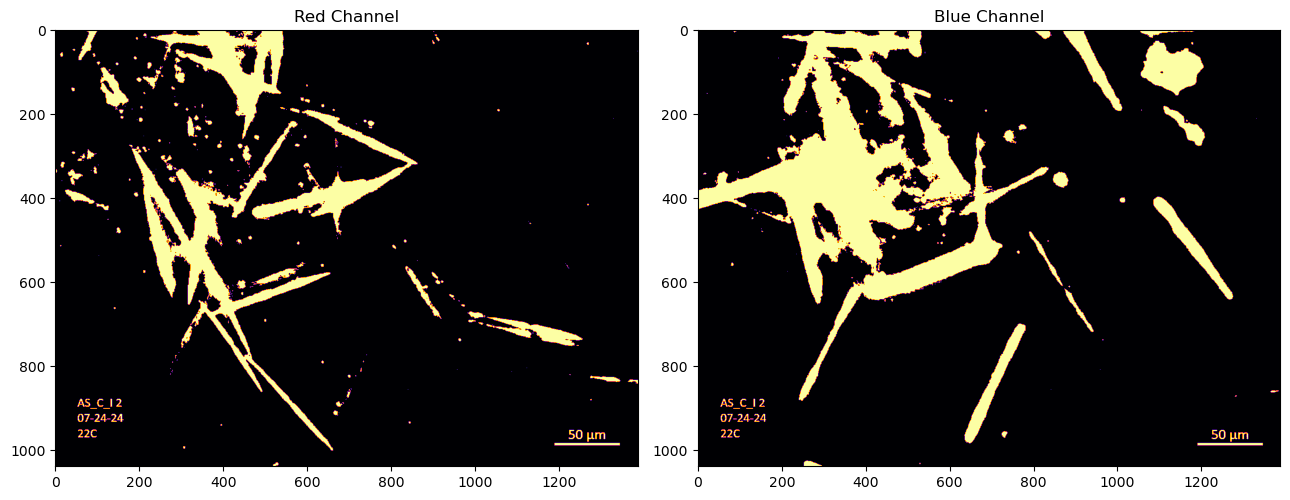

In [12]:
# create masks for red and blue channels
    # threshold to isolate red and blue regions
_, red_mask = cv2.threshold(red_channel, 40, 255, cv2.THRESH_BINARY) # lowering the first value passed can help to detect more cells!!
_, blue_mask = cv2.threshold(blue_channel, 50, 255, cv2.THRESH_BINARY) # this may need to be adjusted for bg noise

    # combine red and blue masks with the cell mask
red_in_cells = cv2.bitwise_and(red_mask, red_mask, mask=mask)
blue_in_cells = cv2.bitwise_and(blue_mask, blue_mask, mask=mask)

# plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Masks")
ax[0].imshow(red_mask, cmap='inferno')
ax[1].imshow(blue_mask, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Red Channel")
ax[1].set_title("Blue Channel")
    # adjust spacing
fig.tight_layout()


Text(0.5, 1.0, 'RGB Image')

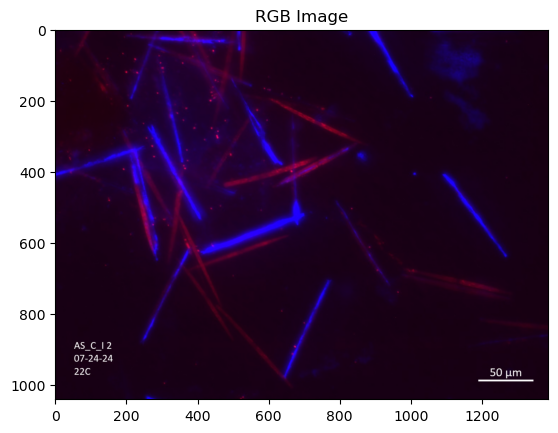

In [15]:
# For comparison, here's the RGB image once again:
fig, ax = plt.subplots(1, 1)
    # show plots
ax.imshow(image_rgb, cmap='magma')
    # set the title to all subplots
ax.set_title("RGB Image")


## Step 5: Calculate Color Ratios

In [17]:
# Step 5: Calculate overall red-to-blue ratio
    # label the individual cells
labeled_cells = label(mask)
regions = regionprops(labeled_cells)

    # instantiate lists to store metrics
cell_count = len(regions)
cell_ratios = []
        # overall_ratio = 

total_red_pixels = np.sum(red_in_cells)
total_blue_pixels = np.sum(blue_in_cells)

    # iterate over each cell
for region in regions:
        # create a mask for the individual cell
    cell_mask = (labeled_cells == region.label).astype(np.uint8) * 255
        # isolate red and blue regions within this cell
    red_in_cell = cv2.bitwise_and(red_in_cells, cell_mask)
    blue_in_cell = cv2.bitwise_and(blue_in_cells, cell_mask)
        # calculate red and blue pixel counts
    red_pixels = np.sum(red_in_cell)
    blue_pixels = np.sum(blue_in_cell)
        # avoid division by zero
    if red_pixels > 0:
        ratio = blue_pixels / red_pixels
    else:
        ratio = np.nan  # or 0 or any other value that makes sense in your context
    cell_ratios.append(ratio)

    # calculate overall red-to-blue ratio
if total_red_pixels > 0:
    overall_ratio = total_blue_pixels / total_red_pixels
else:
    overall_ratio = np.nan  # or 0 or any other value that makes sense in your context
    # print out ratios--do these take intensity into account?
print("Overall blue-to-blue ratio:", overall_ratio)
print("Number of cells:", cell_count) # test image has 35-40 cells
print("Blue-to-red ratios per cell:", cell_ratios)


Overall blue-to-blue ratio: 1.3857338351009236
Number of cells: 15
Blue-to-red ratios per cell: [0.8082191780821918, 1.2789758559873503, 29.447619047619046, nan, 3.171875, 0.0, 179.0, 1.0, 0.0, 9.777262180974478, 1.0, 57.9, 0.9607061503416856, 0.9899705014749263, nan]


## Putting it Together in a Function
Now that we've worked out a basic workflow, let's combine the steps into a function that can be called on a list of images.

In [18]:
def analyze_image(image_path):
    # Step 1: Convert to grayscale and RGB
        # Read in images
    image = cv2.imread(image_path)
        # read in greyscale/bw
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # read in RGB version
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 2: Apply Canny edge detection for RGB images
    edges_rgb = cv2.Canny(image_rgb, threshold1=50, threshold2=150, apertureSize=3, L2gradient=False)
    edges_bw = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3, L2gradient=False)

    # Step 3: Refine edge detection
        # add a Guassian blur
    blurred = cv2.GaussianBlur(gray, (0,0), sigmaX=6, sigmaY=6)
        # morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45,45))
    morph = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)
        # threshold
    thresh = cv2.threshold(morph, 0, 255, cv2.THRESH_OTSU)[1]
        # get contours and filter on size
    masked1 = gray.copy()
    meanval = int(np.mean(masked1))
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        # NOTE: maybe increase pixel size here--match threshold from before, but is this by total pixels in area of contour..?
        if area > 50 and area < 5000:
            cv2.drawContours(masked1, [cntr], 0, (meanval), -1)
    # stretch image based on min & max values detected (dark to light)
    minval = int(np.amin(masked1))
    maxval = int(np.amax(masked1))
    # NOTE: result1 is currently the same as 'gray'
    result1 = skimage.exposure.rescale_intensity(masked1, in_range=(minval,maxval), out_range=(0,255)).astype(np.uint8)
        # apply sobel masking?
    edges = filters.sobel(blurred) #replaced 'result1'
        # Mask to isolate the cells
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)

    # Step 4: Split image into color channels
    red_channel = image_rgb[:, :, 0]
    green_channel = image_rgb[:, :, 1]
    blue_channel = image_rgb[:, :, 2]
        # Create masks for red and blue channels--threshold to isolate red and blue regions
    _, red_mask = cv2.threshold(red_channel, 40, 255, cv2.THRESH_BINARY) # lowering the first value passed can help to detect more cells!!
    _, blue_mask = cv2.threshold(blue_channel, 50, 255, cv2.THRESH_BINARY)
        # Combine red and blue masks with the cell mask
    red_in_cells = cv2.bitwise_and(red_mask, red_mask, mask=mask)
    blue_in_cells = cv2.bitwise_and(blue_mask, blue_mask, mask=mask)
        # combine all color masks
    color_mask = red_mask+blue_mask # same result


    # Step 5: Calculate overall red-to-blue ratio
        # label the individual cells
    labeled_cells = label(mask)
    regions = regionprops(labeled_cells)    
        # instantiate lists to store metrics
    cell_count = len(regions)
    cell_ratios = []
    total_red_pixels = np.sum(red_in_cells)
    total_blue_pixels = np.sum(blue_in_cells)
        # iterate over each cell
    for region in regions:
            # create a mask for the individual cell
        cell_mask = (labeled_cells == region.label).astype(np.uint8) * 255
            # isolate red and blue regions within this cell
        red_in_cell = cv2.bitwise_and(red_in_cells, cell_mask)
        blue_in_cell = cv2.bitwise_and(blue_in_cells, cell_mask)
            # calculate red and blue pixel counts
        red_pixels = np.sum(red_in_cell)
        blue_pixels = np.sum(blue_in_cell)
            # avoid division by zero
        if red_pixels > 0:
            ratio = blue_pixels / red_pixels
        else:
            ratio = np.nan  # or 0 or any other value that makes sense in your context
        cell_ratios.append(ratio)
        # calculate overall red-to-blue ratio
    if total_red_pixels > 0:
        overall_ratio = total_blue_pixels / total_red_pixels
    else:
        overall_ratio = np.nan  # or 0 or any other value that makes sense in your context

    # plotting
    fig, ax = plt.subplots(nrows=2, ncols=3)
        # set main title
    plt.suptitle("Step-Wise Image Analysis")
    ax[0][0].imshow(image_rgb, cmap='magma') # good to show 'image' here
    ax[0][1].imshow(gray, cmap='magma') # good to show 'image' here
    ax[1][0].imshow(edges_rgb, cmap='magma')
    ax[1][1].imshow(edges, cmap='magma')
    ax[0][2].imshow(mask, cmap='magma')
    ax[1][2].imshow(color_mask, cmap='magma')
        # set the title to all subplots
    ax[0, 0].set_title("Step 1: RGB Image")
    ax[0, 1].set_title("Step 1: BW Image")
    ax[1, 0].set_title("Step 2: Canny Edges (RBG)")
    ax[1, 1].set_title("Step 3: Refined Edges (BW)")
    ax[0, 2].set_title("Step 3: Initial Mask")
    ax[1, 2].set_title("Step 4: Combined Color Mask")
        # adjust spacing
    fig.tight_layout()
    
        # print out ratios--do these take intensity into account?
    print('''
    Overall blue-to-blue ratio: {}
    Number of cells: {} 
    Blue-to-red ratios per cell: {}
    '''.format(overall_ratio, cell_count, cell_ratios))

# image locations in GH
image_paths = [
    "../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg",
    "../data/images/ClumpyLate_THN_A_I_15_5_20240726.jpg",
    "../data/images/EasyEarly_AS_A_U_22_5_20240717.jpg",
    "../data/images/GoodEarlySilica_AS_A_I_15_6_20240717.jpg",
    "../data/images/GoodLate_THN_A_I_15_2_20240726.jpg"
]

# image locations in WD
# image_paths = [
#     "../images/ClumpyLate_AS_C_I_22_2_20240724.jpg",
#     "../images/ClumpyLate_THN_A_I_15_5_20240726.jpg",
#     "../images/EasyEarly_AS_A_U_22_5_20240717.jpg",
#     "../images/GoodEarlySilica_AS_A_I_15_6_20240717.jpg",
#     "../images/GoodLate_THN_A_I_15_2_20240726.jpg"
# ]

for img in image_paths:
    print(img)
    analyze_image(img)



../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg


[ WARN:0@14697.118] global loadsave.cpp:241 findDecoder imread_('../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/runner/miniforge3/conda-bld/libopencv_1728017776404/work/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Persisting Challenges:
While I've made progress, several challenges still remain to be solved:
- Remove the corner labels
- Detect *all* red cells (currently, analysis is underestimating cell count, mostly red) 
    - decrease blur around red
    - adjust gradient intensity threshold for mask
    - invert the image to white, what / color balance (looks promising)
- Remove the chlorophyll dots by instantiating specific dimensions (instead of using overall areas)
- Improve the cell masks & calculations
  - we need to account for overlap and cell shape while still accounting for cells with only partial infections
  - we'll also need to balance images based on their specific background (maybe HSV could work)

## Next Steps:
A few alternative approaches might improve my analysis accuracy:
- Implement an approach that includes a blank (in-progress, modeling from Dr. Colleen Durkin: [cadurkin](https://github.com/cadurkin/Sediment_Trap_Gel_Image_Processing_2020/blob/master/Step1_image_processing/Tutorial_Image_Analysis_oblique_EXPORTS.ipynb))
- Separate all steps into autonomous functions so they can be implemented separately and combined (example: [halexander](https://github.com/halexand/FlowCam-Phaeo-Analysis/blob/master/automated_pipeline_flowcam_analysis.ipynb))
- Attempt an HSV approach and use other metrics to detect recalcitrant cells (in progress)
- Check out ML approaches ([Eric Alm](https://web.mit.edu/almlab/) in MIT Bio works on this topic)

## Open Questions:
- Is it acceptable only to count the "brightest" cells, since the workflow may not always catch others?
    - What biases would we be enabling here?
- What can we do with the overall blue:red ratio, versus the individual cell ratios?